# **Final Project Application**

Now that we have effectively trained our Doppelganger model, we wish to test its possible applications in a real-case scenario.

For that, we wanted to try to leverage the embeddings generated by our trained ResNet model in the latent space to find the closest matching face in our dataset for a given input face image. This approach can have several practical applications, such as:

1. **Facial Recognition**: Identifying individuals by comparing their faces to a database of known faces.
2. **Doppelganger Finder**: Finding a person in the dataset who looks most similar to a given input image, which can be fun and engaging for users.
3. **Data Augmentation**: Generating synthetic datasets by finding lookalikes, which can be useful in training other machine learning models.

The key steps involved in implementing this functionality are:

*   **Embedding the Entire Dataset**: Using the trained model to generate embeddings (latent space coordinates) for each image in the dataset.
*   **Embedding and Comparing**: For a given input face image, generate its embedding and find the closest match by calculating the Euclidean distance to all dataset embeddings.

## **Imports**

In [35]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
import json
from tqdm import tqdm
from torchvision.transforms import ToTensor
from mpl_toolkits.mplot3d import Axes3D
from types import MethodType
from torchvision.models import mobilenet_v3_small
import math

In [36]:
# Comment if not in Google Colab
from google.colab import drive
drive.mount('/content/drive')
content_path = '/content/drive/My Drive/DeepLearning_2024/FINAL/'
data_path = content_path + 'dataset/'
results_path = content_path + 'results/'

# Comment if in Google Colab
# data_path = 'data/'
# results_path = 'results/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [38]:
# Define the dataset instance
random_seed = None
dataset_version = 'F_'
model_name = 'resnet'

## **Dataset definition**

In [39]:
class HDA_Doppelgaenger(torch.utils.data.Dataset):

    def __init__(self, datadir = data_path, seed = None, dataset_version = '', transform=None):

        self.datadir = datadir
        self.transform = transform
        self.seed = seed

        with open(data_path + dataset_version + 'dataset.json', 'r') as fp:
            self.indexer = json.load(fp)['HDA_Doppelgaenger']
        """
        with open('./' + dataset_version + 'dataset.json', 'r') as fp:
            self.indexer = json.load(fp)['HDA_Doppelgaenger']
        """
    def __getitem__(self, index):
        np.random.seed(self.seed)
        neg_idx = np.random.randint(0, len(self.indexer)) # index
        np.random.seed(self.seed)
        neg_type = np.random.choice([0, 1]) # original or lookalike

        anchor = Image.open(self.datadir + self.indexer[index][0])
        positive = Image.open(self.datadir + self.indexer[index][1])
        negative = Image.open(self.datadir + self.indexer[neg_idx][neg_type])

        if self.transform is not None :
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)

        return anchor, positive, negative

    def __len__(self):
        return len(self.indexer)

    def mean(self):
        sum = np.zeros(3)
        for i in range(len(self)):
            sum += np.array(self[i][0]).sum(axis=(0,1))
            sum += np.array(self[i][1]).sum(axis=(0,1))
        return sum / (len(self)*2) / 255 / 256**2

    def mean_std(self):
        mean = self.mean()

        sum = np.zeros(3)
        for i in range(len(self)):
            sum += np.power(np.array(self[i][0]), 2).sum(axis=(0,1))
            sum += np.power(np.array(self[i][1]), 2).sum(axis=(0,1))
        sum = sum / (len(self)*2) / 255 / 256**2

        return mean, np.sqrt(sum - np.power(mean, 2))

In [40]:
class ResidualBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None, norm_layer=None):
        super(ResidualBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = norm_layer(planes)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1, bias=False) # in this one stride = 1 then image shape is kept
        self.bn2 = norm_layer(planes)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x): # Tip for improving performance merge all into one line relu(bn2(conv2(relu(bn1(conv1(x))))))
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [41]:
class ResNet(nn.Module):

    def __init__(self, layers, num_classes=1000, zero_init_residual=False, norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        # Introduction layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Layers
        self.layer1 = self._make_layer(64, 64, layers[0])
        self.layer2 = self._make_layer(64, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(128, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(256, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Last fully connected layer
        # self.fc = nn.Linear(512, num_classes)

        # What is going on ???
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        # if zero_init_residual:
        #     for m in self.modules():
        #         if isinstance(m, Bottleneck):
        #             nn.init.constant_(m.bn3.weight, 0)
        #         elif isinstance(m, BasicBlock):
        #             nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, in_planes, out_planes, blocks, stride=1):
        '''
        Creates a layer containing {blocks} ResidualBlocks, where the first one downsamples the output if needed,
        and the next {blocks-1} stacked blocks keep the amount of filters unaltered.
        '''
        norm_layer = self._norm_layer
        downsample = None
        if stride != 1 or in_planes != out_planes:
            downsample = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                norm_layer(out_planes)
            )

        layers = []
        layers.append(ResidualBlock(in_planes, out_planes, stride, downsample, norm_layer))

        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_planes, out_planes, norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        return x

In [42]:
def _forward_impl2(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)

        x = self.avgpool(x)
        # x = torch.flatten(x, 1)

        # x = self.classifier(x)

        return x

## **Loading the pre-trained Model**

In [43]:
def load_model(checkpoint_path):
    pretrained_weights = torch.load(checkpoint_path, weights_only=True, map_location=device)

    if model_name=='resnet':
        net = ResNet([2, 2, 2, 2]).to(device)
        net.load_state_dict(pretrained_weights)
        net.fc = None
    elif model_name=='mobilenet':
        net = mobilenet_v3_small().to(device)
        net._forward_impl = MethodType(_forward_impl2, net)
        net.load_state_dict(pretrained_weights)
    else:
        print('Something\'s wrong...')
    return net

In [44]:
net = load_model(results_path + dataset_version + model_name + '.ckpt')


## **Dataset Embedding**

We start by embedding the entire dataset using the trained ResNet model. This involves generating embeddings (latent space coordinates) for each image in the dataset.

In [45]:
reduction = 10
dataset = HDA_Doppelgaenger(seed=random_seed, dataset_version=dataset_version)

HDA_mean, HDA_std = dataset.mean_std()

base_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(HDA_mean, HDA_std)])

dataset.transform = base_transform

dataset_loader = torch.utils.data.DataLoader(dataset=dataset,
                                              batch_size=int(len(dataset)/reduction),
                                              shuffle=torch._fake_quantize_learnable_per_tensor_affine)





To extract embeddings from a specific layer of the pre-trained model, we follow these steps:

1. **Select Layer**: We specify the layer from which we want to extract embeddings. In this case, we choose the 'avgpool' layer.

2. **Define Embedding Copy Function**: We define a function (`copy_embeddings`) to copy embeddings from the selected layer. Here, we extract embeddings and convert them into NumPy arrays.

3. **Attach Hook to the Layer**: We attach a hook to the selected layer. This hook will execute the `copy_embeddings` function every time the forward pass reaches the specified layer.

4. **Embedding Function**: We modify the embedding function (`embed_hook`) to use the hook. This function iterates through the dataset, performs forward passes on batches of images, and triggers the hook to extract embeddings.

5. **Call the Modified Embedding Function**: We call the modified embedding function (`embed_hook`) with the model, dataset loader, and device as parameters. This process generates embeddings for all images in the dataset.

We were inspired by the approach outlined in the ActiveLoop website, specifically by Margaux Masson-Forsythe's work on generating image embeddings using a pre-trained CNN and storing them in Hub.

**Source**: *https://www.activeloop.ai/resources/generate-image-embeddings-using-a-pre-trained-cnn-and-store-them-in-hub/*



In [46]:
# Define a function to copy embeddings from the selected layer
def copy_embeddings(m, i, o):
    """Copy embeddings from the selected layer."""
    o = o[:, :, 0, 0].detach().cpu().numpy()  # Convert to numpy array
    outputs.append(o)

# Embedding function modified to use the hook
def embed_hook(net, dataloader):
    net.eval()
    total_batches = len(dataloader)
    with torch.no_grad():
        for batch_idx, (anchor, positive, _) in enumerate(dataloader):
            anchor = anchor.to(device)
            positive = positive.to(device)
            _ = net(anchor)  # Forward pass will trigger the hook
            _ = net(positive)
            print(f"Iteration: {batch_idx+1}/{total_batches}")

In [47]:
# Select the desired layer
layer = net._modules.get('avgpool')

outputs = []

# Attach hook to the selected layer
_ = layer.register_forward_hook(copy_embeddings)

# Call the modified embedding function
embed_hook(net, dataset_loader)

# Visualize embeddings
embeddings = np.concatenate(outputs, axis=0)
labels = np.repeat(np.arange(len(dataset)), embeddings.shape[1], axis=0)  # Assuming each image has multiple embeddings

Iteration: 1/10
Iteration: 2/10
Iteration: 3/10
Iteration: 4/10
Iteration: 5/10
Iteration: 6/10
Iteration: 7/10
Iteration: 8/10
Iteration: 9/10
Iteration: 10/10


## **Visualizing Embeddings**

After embedding the dataset, we visualize the embeddings in 2D and 3D spaces for better understanding and interpretation.

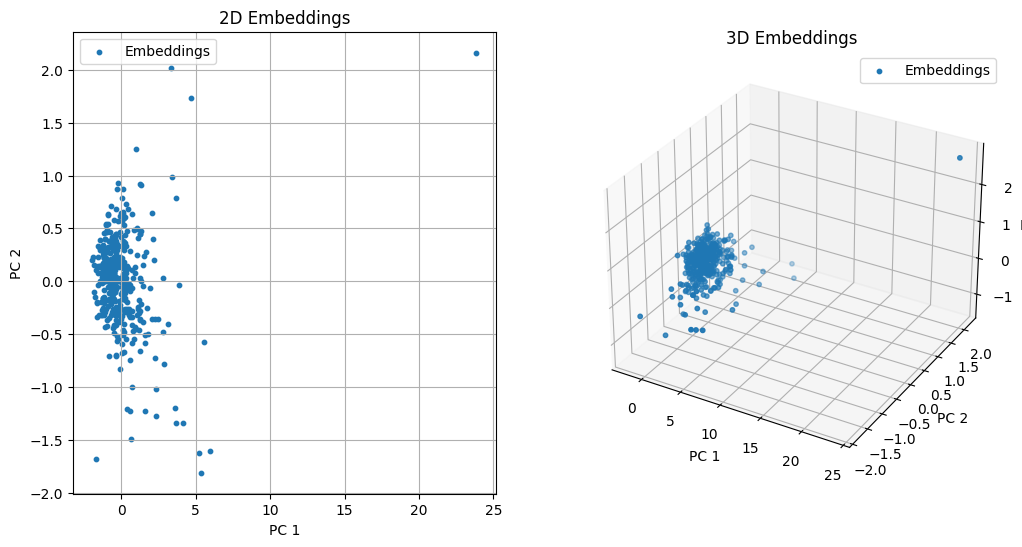

In [67]:
def visualize_embeddings_2d(ax, embeddings, labels, input=None, closest=None):
    # Reshape embeddings to x dimensions
    embeddings_2d = embeddings.reshape(embeddings.shape[0], -1)

    # Perform dimensionality reduction with PCA for visualization
    pca_2d = PCA(n_components=2)
    reduced_embeddings_2d = pca_2d.fit_transform(embeddings_2d)

    # Visualize embeddings in 2D
    scatter_2d = ax.scatter(reduced_embeddings_2d[:, 0], reduced_embeddings_2d[:, 1], s=10, label='Embeddings')
    if input is not None:
        input_2d = pca_2d.transform(input.reshape(1, -1))
        ax.scatter(input_2d[:, 0], input_2d[:, 1], color='red', s=150, label='Input Embedding')
    if closest is not None:
        closest_2d = pca_2d.transform(closest.reshape(1, -1))
        ax.scatter(closest_2d[:,0], closest_2d[:,1], color='green', s=100, label='Closest Embedding')

    ax.set_title('2D Embeddings')
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.grid(True)
    ax.legend()

def visualize_embeddings_3d(ax, embeddings, labels, input=None, closest=None):
    # Reshape embeddings to 3 dimensions
    embeddings_3d = embeddings.reshape(embeddings.shape[0], -1)

    # Perform dimensionality reduction with PCA for visualization
    pca_3d = PCA(n_components=3)
    reduced_embeddings_3d = pca_3d.fit_transform(embeddings_3d)

    # Visualize embeddings in 3D
    scatter_3d = ax.scatter(reduced_embeddings_3d[:, 0], reduced_embeddings_3d[:, 1], reduced_embeddings_3d[:, 2], s=10, label='Embeddings')
    if input is not None:
        input_3d = pca_3d.transform(input.reshape(1, -1))
        ax.scatter(input_3d[:, 0], input_3d[:, 1], input_3d[:, 2], color='red', s=200, label='Input Embedding')
    if closest is not None:
        closest_3d = pca_3d.transform(closest.reshape(1, -1))
        ax.scatter(closest_3d[:, 0], closest_3d[:, 1], closest_3d[:, 2], color='green', s=150, label='Closest Embedding')
    ax.set_title('3D Embeddings')
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.set_zlabel('PC 3')
    ax.grid(True)
    ax.legend()

fig = plt.figure(figsize=(12, 6))
axs = [fig.add_subplot(1, 2, 1), fig.add_subplot(1, 2, 2, projection='3d')]


visualize_embeddings_2d(axs[0], embeddings, labels)
visualize_embeddings_3d(axs[1], embeddings, labels)

## **Find Doppelganger**

### **Test**

To test if our idea seems correct, we will test with a single image first. We will first find which is its coordinates in the embedding space (in red) and then compute the euclidean distances from that point and keep the argmin of that vector. The closest image found will then be also represented in the latent space (in green) and the image will be displayed.

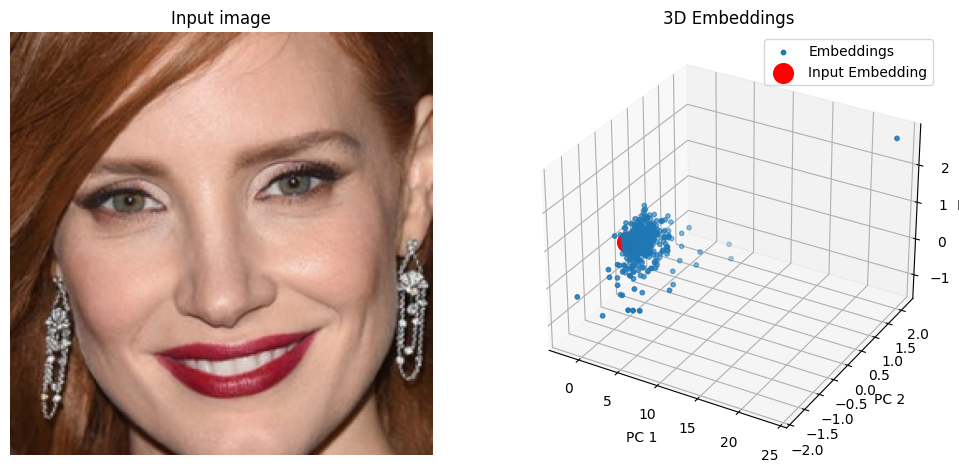

In [73]:
fig = plt.figure(figsize=(12, 6))
axs = [fig.add_subplot(1, 2, 1), fig.add_subplot(1, 2, 2, projection='3d')]

image_path = data_path + 'F_101_Original.png'
image = Image.open(image_path)


transformed_image = base_transform(image).unsqueeze(0).to(device)
with torch.no_grad():
    embedded_image = net(transformed_image).cpu().detach().numpy()

axs[0].set_title('Input image')
axs[0].imshow(image)
axs[0].axis('off')

axs[1].set_title('Embedding')

visualize_embeddings_3d(axs[1], embeddings, labels, input=embedded_image)

Now let's find the closest image to this embedding using Euclidean Distances.

(-0.5, 255.5, 255.5, -0.5)

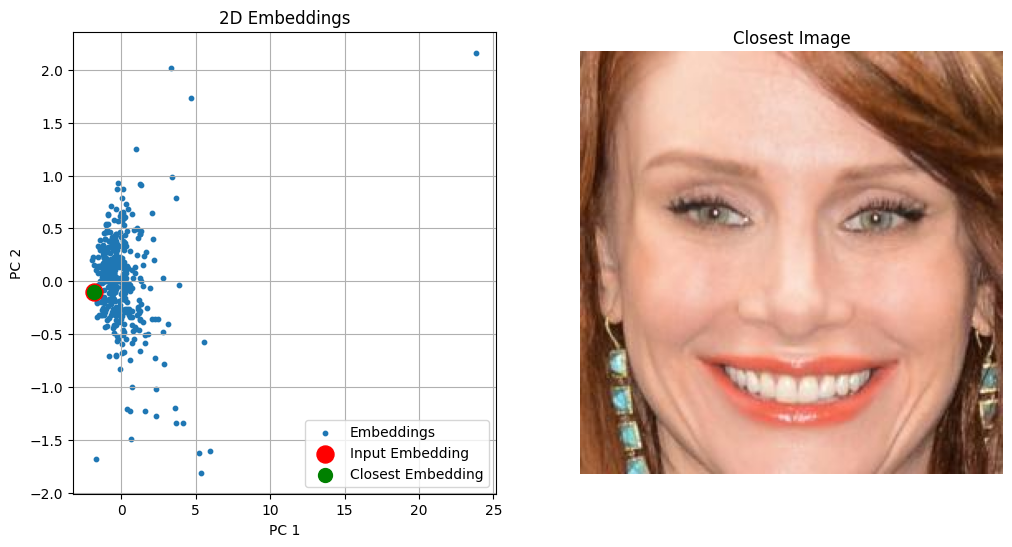

In [74]:
distances = np.linalg.norm(embeddings.T - embedded_image, axis=0)
closest_index = np.argmin(distances)
closest_embedding = embeddings[closest_index, :]
closest_embedding = closest_embedding.reshape(1, -1)
closest_image_path = dataset.indexer[math.floor(closest_index/2)][closest_index%2]

fig = plt.figure(figsize=(12, 6))
axs = [fig.add_subplot(1, 2, 1), fig.add_subplot(1, 2, 2)]

embedded_image = embedded_image.squeeze()
axs[0].set_title('Closest Image Embedding')
visualize_embeddings_2d(axs[0], embeddings, labels, input=embedded_image, closest=closest_embedding)


axs[1].set_title('Closest Image')
axs[1].imshow(Image.open(data_path + closest_image_path))
axs[1].axis('off')



### **Dataset**
Let's now finally apply our method to a selection of samples, by creating a function to automate the process.

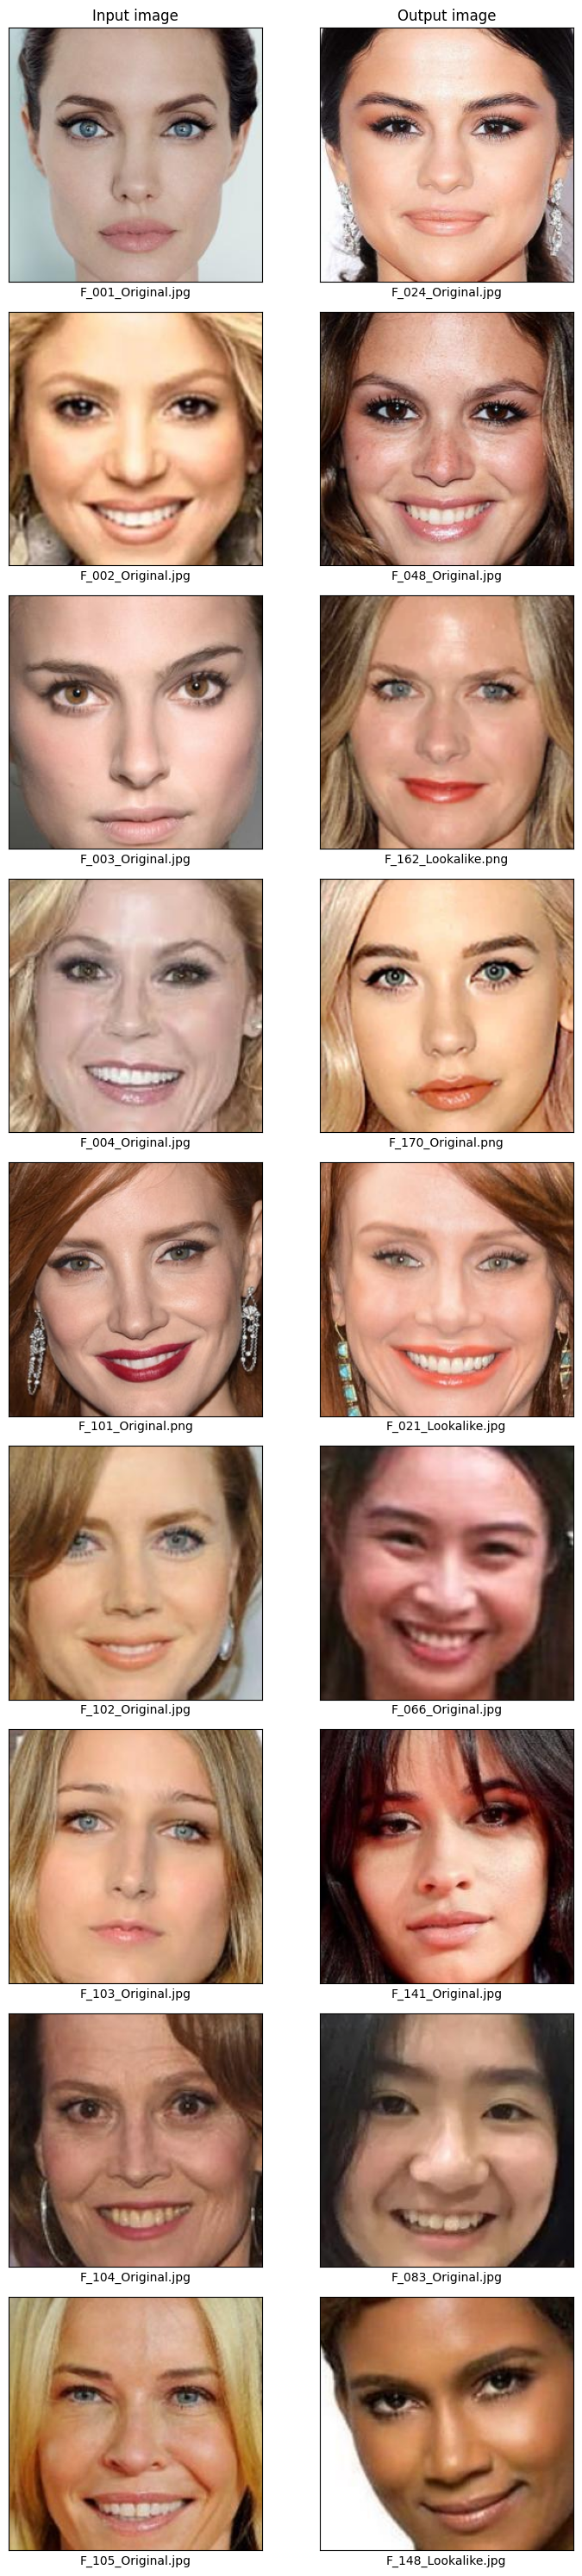

In [77]:
def find_doppelganger(model, embeddings, dataset, image, transform=None):

    query_image = transform(image).unsqueeze(0).to(device)

    # Obtain the embedding for the query image and visualize it within the embedding space of the dataset
    with torch.no_grad():
        embedded_image = net(query_image).cpu().detach().numpy()

    # Calculate Euclidean distances between the query embedding and all embeddings in the embedding space
    distances = np.linalg.norm(embeddings.T - embedded_image, axis=0)

    # Find the index of the closest embedding
    closest_index = np.argmin(distances)

    # Retrieve the corresponding image from the dataset
    closest_image_path = dataset.indexer[math.floor(closest_index/2)][closest_index%2]

    return closest_image_path

samples = 5
fig, axs = plt.subplots(samples*2-1, 2, sharex=True, sharey=True, figsize=(8, 30))
axs[0][0].set_title('Input image')
axs[0][1].set_title('Output image')

for im in range(samples):
    input_im_path = data_path + dataset.indexer[im][0]
    input_im = Image.open(input_im_path)

    closest_image_name = find_doppelganger(net, embeddings, dataset, input_im, transform=base_transform)
    # print('In: {}, Out: {}'.format(dataset.indexer[im][0], closest_image_name))
    axs[im][0].imshow(input_im)
    axs[im][0].set_xlabel(dataset.indexer[im][0])
    axs[im][1].imshow(Image.open(data_path + closest_image_name))
    axs[im][1].set_xlabel(closest_image_name)

for im in range(samples):
    input_im_path = data_path + dataset.indexer[int(len(dataset)/2)+im][0]
    input_im = Image.open(input_im_path)

    closest_image_name = find_doppelganger(net, embeddings, dataset, input_im, transform=base_transform)
    # print('In: {}, Out: {}'.format(dataset.indexer[int(len(dataset)/2)+im][0], closest_image_name))
    axs[samples-1+im][0].imshow(input_im)
    axs[samples-1+im][0].set_xlabel(dataset.indexer[int(len(dataset)/2)+im][0])
    axs[samples-1+im][1].imshow(Image.open(data_path + closest_image_name))
    axs[samples-1+im][1].set_xlabel(closest_image_name)

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()